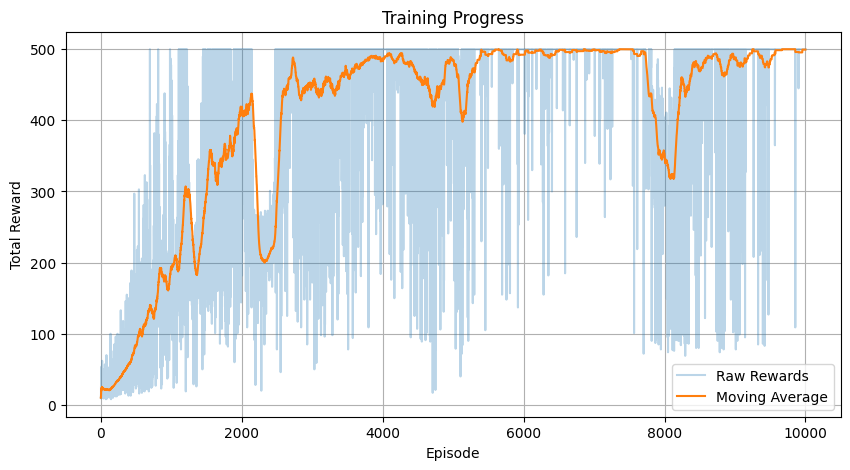

In [1]:
import sys
sys.path.append('..')

import gym
import torch
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
import time  # 添加这行来控制显示速度

from models.policy_network import PolicyNetwork
from models.utils import ExperienceBuffer, plot_training_results

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = 'cpu'
print(f"Using device: {device}")
# torch.manual_seed(123)
# 创建环境
env = gym.make('CartPole-v1')
input_dim = env.observation_space.shape[0]  # 4 （状态空间维度 = 4 (小车位置、速度、杆子角度、角速度)）
output_dim = env.action_space.n  # 2 动作空间维度 = 2 (左推或右推)
hidden_dim = 256

# 创建策略网络和优化器
policy = PolicyNetwork(input_dim, hidden_dim, output_dim,device) # 策略网络：状态->动作概率
optimizer = optim.Adam(policy.parameters(), lr=0.0001)

# 创建经验缓冲区
buffer = ExperienceBuffer(device)

# 训练参数
num_episodes = 10000
max_steps = 500
episode_rewards = []

# 训练循环
for episode in range(num_episodes):
    state, _ = env.reset()
    episode_reward = 0
    buffer.reset()
    
    # 收集一个episode的经验
    for step in range(max_steps):
        action, log_prob = policy.select_action(state)
         # log_prob 是选择该动作的对数概率，用于后续计算策略梯度
        try:
            result = env.step(action)
            if len(result) == 5:
                next_state, reward, terminated, truncated, _ = result
                done = bool(terminated) or bool(truncated)
            else:
                next_state, reward, done, _ = result
                done = bool(done)
        except Exception as e:
            print(f"Error during step: {e}")
            break
        
        buffer.add(reward, log_prob)
        episode_reward += reward
        
        if done:
            break
            
        state = next_state
    
    # 只在有足够数据时更新策略
    if len(buffer.rewards) > 0:
        optimizer.zero_grad()
        loss = buffer.get_policy_loss()
        loss.backward()
        optimizer.step()
    
    episode_rewards.append(episode_reward)
    
    # 每10个episode打印一次平均奖励
    if (episode + 1) % 10 == 0:
        avg_reward = np.mean(episode_rewards[-10:])
        print(f'Episode {episode + 1}, Average Reward: {avg_reward:.2f}')
        
        # 绘制实时训练进度
        clear_output(wait=True)
        plt.figure(figsize=(10, 5))
        moving_averages = plot_training_results(episode_rewards)
        plt.plot(episode_rewards, alpha=0.3, label='Raw Rewards')
        plt.plot(moving_averages, label='Moving Average')
        plt.xlabel('Episode')
        plt.ylabel('Total Reward')
        plt.title('Training Progress')
        plt.legend()
        plt.grid(True)
        plt.show()


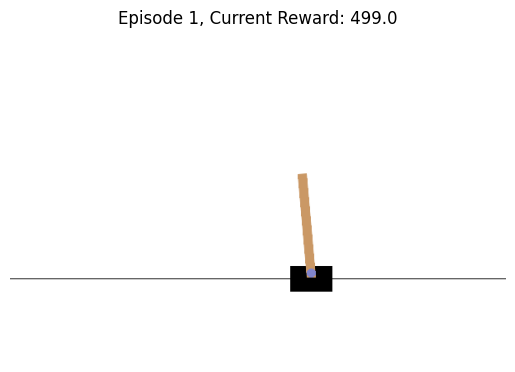

Episode 1 finished with reward 500.0


In [2]:
from models.utils import show_agent
# 展示训练结果
show_agent(env, policy,1)

In [3]:
# save the model

save_path = '../saved_model'
import os

# Create directory if it doesn't exist
if not os.path.exists(save_path):
    os.makedirs(save_path)

# Save the model
model_path = os.path.join(save_path, 'policy_model.pth')
torch.save(policy.state_dict(), model_path)
print(f"Model saved to {model_path}")



Model saved to ../saved_model/policy_model.pth


In [ ]:
""" 使用策略梯度(Actor-Critic)方法训练CartPole-v1环境的智能体 """
import numpy as np
import pickle
import gym
import copy

# 超参数设置
H = 64  # 隐藏层神经元数量
batch_size = 32  # 每多少回合更新一次策略
learning_rate = 1e-3  # 学习率
gamma = 0.99  # 奖励折扣因子
decay_rate = 0.99  # RMSProp的衰减率
mom_rate = 0.9  # 动量因子
td_step = 10  # TD(n)中的n步数
gamma_power = [gamma**i for i in range(td_step+1)]  # 预计算gamma的n次方
rmsprop = True  # 是否使用RMSProp优化器
resume = False  # 是否从检查点恢复训练
render = False  # 是否渲染环境

# 模型初始化
D = 4  # 输入维度: CartPole状态空间为4维向量
if resume:
    model, model_target = pickle.load(open('save_cartpole.ac', 'rb'))
else:
    model = {}
    # 策略网络(Actor)参数初始化
    model['W1_policy'] = np.random.randn(H,D) / np.sqrt(D)  # Xavier初始化
    model['b1_policy'] = np.random.randn(H) / np.sqrt(4*H)
    model['W2_policy'] = np.random.randn(1,H) / np.sqrt(H)  # 输出层为1个神经元(二分类)
    model['b2_policy'] = 0.0
    # 价值网络(Critic)参数初始化
    model['W1_value'] = np.random.randn(H,D) / np.sqrt(D)
    model['b1_value'] = np.random.randn(H) / np.sqrt(4*H)
    model['W2_value'] = np.random.randn(1,H) / np.sqrt(H)
    model['b2_value'] = 0.0
    model_target = copy.deepcopy(model)  # 创建目标网络副本

# 初始化梯度缓冲区和优化器状态
grad_buffer = { k : np.zeros_like(v) for k,v in model.items() }  # 批次梯度累积
momentum = { k : np.zeros_like(v) for k,v in model.items() }  # 动量
rmsprop_cache = { k : np.zeros_like(v) for k,v in model.items() }  # RMSProp缓存

def sigmoid(x): 
    """Sigmoid激活函数"""
    return 1.0 / (1.0 + np.exp(-x))

def forward(x, modelType, model=model):
    """前向传播
    Args:
        x: 输入状态
        modelType: 'policy'或'value'表示使用哪个网络
        model: 使用的模型参数
    Returns:
        out: 网络输出
        h: 隐藏层激活值
    """
    h = np.dot(model['W1_'+modelType], x) + model['b1_'+modelType]
    h[h<0] = 0  # ReLU激活函数
    out = np.dot(model['W2_'+modelType], h) + model['b2_'+modelType]
    if modelType == 'policy':
        out = sigmoid(out)  # 策略网络使用sigmoid得到动作概率
    return out, h

def backward(eph, epx, epd, modelType):
    """反向传播计算梯度
    Args:
        eph: 隐藏层激活值历史
        epx: 输入状态历史
        epd: 误差项
        modelType: 'policy'或'value'表示哪个网络的梯度
    Returns:
        各参数的梯度字典
    """
    db2 = sum(epd)[0]
    dW2 = np.dot(eph.T, epd).ravel()
    dh = np.outer(epd, model['W2_'+modelType])
    dh[eph <= 0] = 0  # ReLU导数
    db1 = sum(dh)
    dW1 = np.dot(dh.T, epx)
    return {'W1_'+modelType:dW1, 'W2_'+modelType:dW2, 'b1_'+modelType:db1, 'b2_'+modelType:db2}

# 创建环境
if render:
    env = gym.make("CartPole-v1", render_mode='human')
else:
    env = gym.make("CartPole-v1")

observation, _ = env.reset()
xs,h_ps,h_vs,dlogps,vs,tvs,dvs = [],[],[],[],[],[],[]  # 轨迹存储列表
running_reward = None
reward_sum = 0
round_number = 0

while True:
    # 直接使用原始状态作为网络输入
    x = observation
    
    # 通过策略网络计算动作概率并采样动作
    aprob, h_p = forward(x,'policy')
    action = 1 if np.random.uniform() < aprob else 0  # 采样动作: 1或0
    
    # 通过价值网络计算状态价值
    v,h_v = forward(x,'value')
    tv,_ = forward(x,'value',model_target)
    
    # 记录轨迹
    xs.append(x)
    h_ps.append(h_p)
    h_vs.append(h_v)
    vs.append(v)
    tvs.append(tv)
    y = 1 if action == 1 else 0
    dlogps.append(y - aprob)  # 计算策略网络的对数概率梯度
    
    # 与环境交互一步
    observation, reward, done, info, _ = env.step(action)
    reward_sum += reward
    
    if done:
        round_number += 1
        
        # 计算TD误差
        dvs = [0]*len(vs)
        for i in range(len(vs)):
            if len(vs) - 1 - i < td_step:
                dvs[i] = reward*(gamma_power[len(vs) - 1 - i]) - vs[i]
            else:
                dvs[i] = gamma_power[td_step]*tvs[i+td_step] - vs[i]
        
        # 整理轨迹数据
        epx = np.vstack(xs)
        eph_p = np.vstack(h_ps)
        eph_v = np.vstack(h_vs)
        epdlogp = np.vstack(dlogps)
        epv = np.vstack(dvs)
        xs,h_ps,h_vs,dlogps,vs,tvs,dvs = [],[],[],[],[],[],[]  # 清空轨迹
        
        # 计算策略梯度
        epdlogp *= epv  # 使用优势函数调整策略梯度
        grad_p = backward(eph_p,epx,epdlogp,'policy')
        grad_v = backward(eph_v,epx,epv,'value')
        grad = dict(grad_p,**grad_v)
        
        # 累积批次梯度
        for k in model:
            grad_buffer[k] += grad[k]
        
        # 每batch_size回合更新一次参数
        if round_number % batch_size == 0:
            for k,v in model.items():
                g = grad_buffer[k]
                if rmsprop:
                    rmsprop_cache[k] = decay_rate * rmsprop_cache[k] + (1 - decay_rate) * g**2
                    momentum[k] = mom_rate * momentum[k] + learning_rate * g / (np.sqrt(rmsprop_cache[k]) + 1e-5)
                else:
                    momentum[k] = mom_rate * momentum[k] + learning_rate * g
                model[k] += momentum[k]
                grad_buffer[k] = np.zeros_like(v)
                
                # 更新目标网络
                if 'value' in k:
                    model_target[k] = mom_rate * model_target[k] + (1-mom_rate) * model[k]
            
            print(f'回合 {round_number} 完成, 总奖励: {reward_sum}')
            if round_number % 100 == 0:
                pickle.dump((model,model_target), open('save_cartpole.ac', 'wb'))
        
        # 更新运行平均奖励
        running_reward = reward_sum if running_reward is None else running_reward * 0.99 + reward_sum * 0.01
        print(f'重置环境. 本回合总奖励: {reward_sum}. 运行平均: {running_reward}')
        reward_sum = 0
        observation, _ = env.reset()